In [70]:
import warnings
warnings.filterwarnings('ignore')

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [128]:
# read in data and look at target variable
data = pd.read_csv('LoanStats3a.csv')

In [116]:
data.shape

(42538, 144)

In [117]:
TARGET_VAR = 'loan_status'

<Axes: xlabel='loan_status', ylabel='Count'>

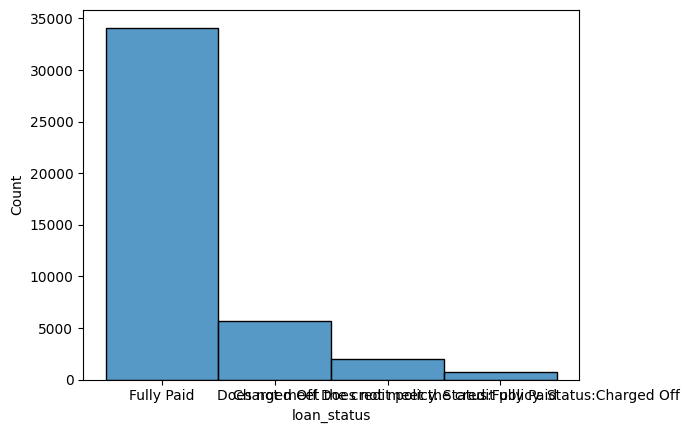

In [118]:
sns.histplot(data[TARGET_VAR])

We are looking to determine whether or not the loan is expected to be paid off, so we can binarize these into "Fully Paid" and everything else. Inspect the data a bit more.

In [ ]:
categorical_features = [x for x in data.dtypes.keys() if data.dtypes[x] == object]
numeric_features = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]
print(f'CATEGORICALS: {len(categorical_features)}')
print(f'NUMERIC: {len(numeric_features)}')

for cat in categorical_features:
    print(cat.upper())
    print(data[cat].describe())

We have some categorical and many numeric features. After inspecting the data, we find that we need to convert some categoricals to either binary or numeric. We will one-hot-encode any categorical features that have only a small number of classes. Lastly, we'll drop any remaining features that have very few classes or are largely NaN. 

In [129]:
DROP = ['member_id'] # drop member id, add more to this list as we go
# take only instances that aren't missing target var
data = data[data[TARGET_VAR].notna()].copy()
# replace NaN with 0
data.fillna(0, inplace=True)

# Convert target vars to 0 and 1
data['loan_status'] = data['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

# convert Y/N to 0 and 1
data['debt_settlement_flag'] = data['debt_settlement_flag'].apply(lambda x: 1 if x == 'Y' else 0)

# Convert percentage strings to floats
for var in ['revol_util', 'int_rate']:
    data[var] = data[var].apply(lambda x: float(str(x).replace('%', '')))

# Convert "N months" to int
data['term'] = data['term'].apply(lambda x: int(str(x).replace(' months', '')))

# Convert letter grade to numeric
letter_mapping = {n: i for i, n in enumerate(list('ABCDEFG'))}
data['grade'] = data['grade'].apply(lambda x: letter_mapping[x])

# Engineer some more features that could be helpful
data['diff_installment_last_pymnt'] = data['installment'] - data['last_pymnt_amnt'] # difference between monthly installent amount and amount paid
data['total_repayment_amnt'] = data['installment'] * data['term'] # total amount to be repaid
data['fund_amt_per_month'] = data['funded_amnt'] / data['term'] # amount loaned broken down by month

for f in data.columns:
    if data[f].value_counts().shape[0] == 1:
        DROP.append(f)

# and then a couple others that had very few classes or data was missing for the vast majority of instances
DROP.extend(
    [
        'tax_liens', 
        'delinq_amnt', 
        'settlement_date', 
        'debt_settlement_flag_date', 
        'settlement_status', 
        'verification_status'
    ]
)
# Next payment date seems irrelevant for predicting loan default
DROP.append('next_pymnt_d')

# Drop other categorical variables for now, just to get a baseline model
DROP.extend(
    [
        'last_credit_pull_d', 
        'last_pymnt_d', 
        'earliest_cr_line', 
        'issue_d', 
        'desc',
        'home_ownership',
        'purpose',
        'settlement_status',
        'verification_status',
        'addr_state',
        'zip_code',
        'emp_length',
        'emp_title',
        'sub_grade',
        'title'
    ]
)

target = data[TARGET_VAR]
df = data.loc[:,list(set(data.columns) - set(DROP + [TARGET_VAR]))]

df.shape

(42535, 35)

Train the model so we can look at some residuals.

In [130]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X = df.values
y = target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

Check performance on test set.

In [131]:
# save output for comparing later
clf_report = classification_report(y_test, clf.predict(X_test), output_dict=True)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.78      0.87      1611
           1       0.95      1.00      0.97      6896

    accuracy                           0.96      8507
   macro avg       0.96      0.89      0.92      8507
weighted avg       0.96      0.96      0.95      8507



Accuracy is excellent. F1 for class 1 also looks good. The priority here is clearly improving recall for class 0. First, check some goodness-of-fit metrics and plot residuals.

In [132]:
from sklearn.metrics import mean_squared_error

y_pred = clf.predict_proba(X_test)[:, 1]
residuals = y_test - y_pred

# Number of observations and number of predictors
n = len(y)
p = X.shape[1]

mse = mean_squared_error(y_test, y_pred)
ssr = np.sum((y_pred - np.mean(y)) ** 2)
rss = np.sum(residuals ** 2)
f_stat = (ssr / p) / (rss / (n - p - 1))

print('Mean Squared Error:', mse, '\nF-statistic:', f_stat)

Mean Squared Error: 0.04178108779006172 
F-statistic: 3341.7145585597364


MSE is low and F-statistic is high, so that's good.

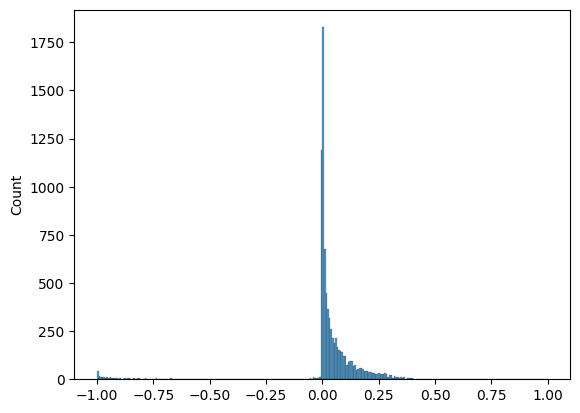

In [123]:
sns.histplot(residuals)
plt.show()

This plot of residuals tells the same story as the classification report: we have a positive bias, wherein we overestimate the probability of the positive class. Perform error analysis on these FNs.

In [ ]:
# temp df to store features, expected val, predicted val, and isolate false negatives
temp_df = pd.DataFrame(X_test, columns=df.columns)
temp_df['y_expected'] = y_test
temp_df['y_pred'] = clf.predict(X_test)
temp_df['is_fn'] = (temp_df['y_expected'] == 0) & (temp_df['y_pred'] == 1)
temp_df['is_fn'] = temp_df['is_fn'].astype(str)

# set up space to show plots
num_features = len(temp_df.columns) - 3
rows = (num_features + 2) // 3
cols = min(num_features, 3)


fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

# for each feature, plot the false negatives
for i, feature_name in enumerate(temp_df.columns[:-3]):
    sns.boxplot(y=temp_df.iloc[:, i], x=None, hue=temp_df['is_fn'], data=temp_df, palette={'False': 'blue', 'True': 'red'}, legend=False, ax=axes[i])
    axes[i].set_title(f'{feature_name}', fontsize=10)
    axes[i].set_xlabel('Misclassified (Class 0)', fontsize=8)
    axes[i].set_ylabel(feature_name, fontsize=8)
    axes[i].tick_params(axis='both', which='major', labelsize=7)
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['False', 'True'], fontsize=7)

# Remove any unused subplots
if num_features < rows * cols:
    for j in range(num_features, rows * cols):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The plots above showed the most difference in distribution with 2 features--so look at those more closely, engineer features from them, and try training again.

In [107]:
tmp = temp_df[['inq_last_6mths', 'grade', 'is_fn']].copy()
tmp.groupby('is_fn').agg(['mean', 'median', 'min', 'max', 'std'])

inq_last_6mths                                 grade                   \
                mean median  min   max       std      mean median  min  max   
is_fn                                                                         
False       0.925368    1.0  0.0  18.0  1.199928  1.599877    1.0  0.0  6.0   
True        4.201729    4.0  0.0  24.0  3.182266  2.778098    3.0  0.0  6.0   

                 
            std  
is_fn            
False  1.422190  
True   1.474164

In [134]:
df['inq_6m_greaterthan'] = np.where(df['inq_last_6mths'] > 18, 1, 0)
df['grade_greaterthan'] = np.where(df['grade'] > 3, 1, 0)

In [135]:
X = df.values
y = target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [136]:
clf_report_new = classification_report(y_test, clf.predict(X_test), output_dict=True)

In [137]:
pd.DataFrame(clf_report)

,0,1,accuracy,macro avg,weighted avg
precision,0.975309,0.951879,0.955448,0.963594,0.956316
recall,0.784606,0.995360,0.955448,0.889983,0.955448
f1-score,0.869625,0.973134,0.955448,0.921379,0.953532
support,1611.000000,6896.000000,0.955448,8507.000000,8507.000000


In [138]:
pd.DataFrame(clf_report_new)

,0,1,accuracy,macro avg,weighted avg
precision,0.976834,0.952024,0.955801,0.964429,0.956723
recall,0.785227,0.995650,0.955801,0.890438,0.955801
f1-score,0.870613,0.973348,0.955801,0.921980,0.953893
support,1611.000000,6896.000000,0.955801,8507.000000,8507.000000


Difference is negligible, but check GOF and residuals one more time.

In [140]:
# previous GOF stats
print('Mean Squared Error:', mse, '\nF-statistic:', f_stat)

Mean Squared Error: 0.04178108779006172 
F-statistic: 3341.7145585597364


In [141]:
y_pred = clf.predict_proba(X_test)[:, 1]
residuals = y_test - y_pred

# print previous GOF stats

# Number of observations and number of predictors
n = len(y)
p = X.shape[1]

new_mse = mean_squared_error(y_test, y_pred)
ssr = np.sum((y_pred - np.mean(y)) ** 2)
rss = np.sum(residuals ** 2)
new_f_stat = (ssr / p) / (rss / (n - p - 1))

print('Mean Squared Error:', new_mse, '\nF-statistic:', new_f_stat)

Mean Squared Error: 0.04223000220542109 
F-statistic: 3105.470612709431


MSE is slightly higher, F-stat is lightly lower (both bad)

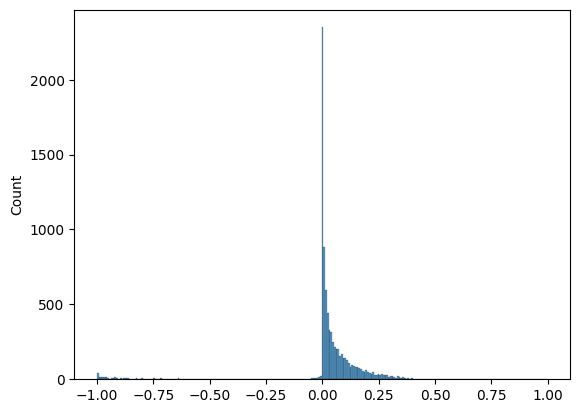

In [142]:
sns.histplot(residuals)
plt.show()

Same problems still exist. The top two things to try next are going back to the categorical features we chose to drop, and looking at feature scaling.